In [ ]:
# Objectives
#After completing this lab you are able to:

# Perform EDA using a set of very simple and easy-to-memorize Python commands
# Interpret key EDA plots and statistics
# Improve a prediction model by using information obtained through EDA
# Perform basic feature engineering
# Detect and handle outliers
# Deal with missing data

In [ ]:
# Setup

# For this lab, we use the following libraries:

# pandas for managing the data
# NumPy for mathematical operations
# SciPy for additional mathematical operations beyond those provided by numpy
# sklearn for machine learning and machine learning pipeline-related functions
# seaborn for visualizing the data
# Matplotlib for additional plotting tools
# MissingNo for missing data analysis and visualizations
# fasteda for fast and easy EDA

In [ ]:
# Install required libraries
# Although many of the Python libraries we use in this project are pre-installed, 
# some of them are not. Run the following code block to install the missing required libraries.
# Note that this code take approximately 60 seconds to run.

In [2]:
%pip install scikit-learn==1.4.1.post1 seaborn==0.13.2 fasteda==1.0.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import required libraries
# Run the following code to import the required libraries and to perform some initial steps to set up the Python environment.

import random
random.seed(2024)

import missingno as msno
import numpy as np
from scipy.stats import shapiro
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from fasteda import fast_eda

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [5]:
# Load the data from `sklearn` as two pandas.DataFrame
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Concatenate the two pandas.DataFrames into one
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the data set from `sklearn` using another method in order to print 
# the data set description of the data
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [ ]:
# Regression
# In this section, learn how to perform EDA on a data set with the goal of building a predictive model that is focused on
#regression. Simply put, a regression objective entails predicting a particular value for a numeric outcome variable, 
#like a student's test score or a worker's income, based on various observable factors, called features.

# For this section, you work with a data set that's aimed at predicting a numeric estimate of diabetes progression one year
# after a baseline. In other words, for each patient (observation), the goal is to predict a numeric score indicating 
#diabetes progression one year after their blood pressure, body mass index, and blood sugar level were recorded.

In [23]:
# Clearly, you have 10 features and a target column. As was mentioned previously, the target is a quantitative measure of 
# diabetes progression one year after a baseline diabetes level was established. Your task is to predict this measure of 
# disease progression on the basis of the observed features.

# Most of the features are numeric, except for sex, which is a categorical feature with 1.0 representing either female or
# male (it is not clear from the data description) and 2.0 representing the opposite sex. Variables s1 through s6 are as 
# defined in the data description.

diabetes.sample(5)



,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
400,42.0,1.0,1.0,1.0,1.0,1.0,30.6,121.00,176.0,92.8,69.0,3.00,4.2627,89.0,175.0
200,64.0,1.0,1.0,1.0,1.0,1.0,21.0,92.33,227.0,146.8,65.0,3.49,4.3307,102.0,158.0
342,64.0,0.0,0.0,0.0,0.0,0.0,28.4,111.00,184.0,127.0,41.0,4.00,4.3820,97.0,178.0
156,44.0,1.0,1.0,1.0,1.0,1.0,25.4,95.00,162.0,92.6,53.0,3.00,4.4067,83.0,25.0
441,36.0,1.0,1.0,1.0,1.0,1.0,19.6,71.00,250.0,133.2,97.0,3.00,4.5951,92.0,57.0


In [7]:
# Add some missing values
# The original data set does not contain any missing values. 
#To verify this, run the following code, which outputs True if there are missing values and False otherwise.

diabetes.isna().max(axis=0).max()

False

In [11]:
# To derive the most benefit from this EDA exercise, you introduce some missing values.
# Specifically, you select 3 feature columns at random, and set them to missing for 10% of randomly selected rows.

# Set the random seed for reproducibility
random.seed(2024)

# Select 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

# Select 10% of the rows at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))

# Set the 3 selected columns to missing values for the 10% of selected rows
diabetes.iloc[missing_rows, missing_cols] = np.nan

In [15]:
# To see which columns were randomly selected, run the following cell.

print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


In [ ]:
# You see that bmi, s1, and s4 have been randomly selected, resulting in missing values in these columns. 
#It's important to note that although these columns were selected randomly, 
# the use of the random.seed() method in the previous code block ensures that the exact same random realization occurs 
# every time the previous code is executed.

In [ ]:
# Initial data preprocessing
# In this step, you perform some initial data preprocessing necessary to use the data in a prediction model.

# In a typical workflow, data preprocessing is usually conducted after EDA. After all,
# how can one determine the necessary preprocessing steps without thoroughly examining the data first? However, 
# in this case, you're moving these initial preprocessing steps earlier to allow for building multiple prediction models 
# based on insights gained from EDA, aiming to enhance the predictive performance of each successive model. Note that some
# level of preprocessing is essential for building any useful model. Therefore, you'll carry out this initial preprocessing here,
#with the understanding that in a standard workflow, these steps would typically occur after EDA.

In [ ]:
# One-hot encoding

# Recall that the sex column encodes female and male with 1.0 and 2.0, where it is not clear from the data set documentation 
# which code belongs to which sex. If you were to keep this column encoded as is, then prediction models would interpret this 
# column as having a particular ordering, which is not what you want because sexes have no inherent order. Rather, 
# it would be better to one-hot encode this data, where you split the sex column into two columns: one for each category. 
# The data transformation afforded by one-hot encoding is best illustrated by an example:

In [20]:
# Initialize the one-hot encoder
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# One-hot encode 'sex'; the output is a numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

# Convert numpy array to pandas DataFrame with columns names based on original category labels
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])

# Horizontally concatenate the original 'diabetes' data set with the two one-hot columns
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex', 'sex1', 'sex2']].sample(10)

,sex,sex1,sex1,sex1,sex1,sex1,sex2,sex2,sex2,sex2,sex2
180,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
327,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
373,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
250,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
245,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
288,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
228,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
329,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
322,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
117,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# The previous table shows the original sex column, and the two columns into which the sex column was split into using 
# one-hot encoding: sex1 and sex2. Note that when sex takes the value of 1.0, the sex1 column takes the value of 1.0 and 
# the sex2 column takes the value of 0.0. Likewise, when sex takes the value of 2.0, the sex1 column takes the value of 0.0 
# and the sex2 column takes the value of 1.0. So one-hot encoding essentially splits a categorical variable into a series of 
# indicator columns, where the indicator is equal to 1.0 if the category is present and 0.0 otherwise.

# Now, instead of keeping both the sex1 and sex2 columns in your new data set, you only keep one column, say sex1,
# because after you have one of these columns, the other column does not add any useful information to the model. 
# In other words, when sex1 is equal to 1.0, then sex2 must be equal to 0.0, and vice versa. Essentially,
# this is equivalent to saying that, if you knew that an individual is female, then you know that they are not male,
# and vice versa. Consequently, you would need to keep only one of the columns, either the one for female or the one for male, 
# because the other column does not give you any useful information after you have the first column. 
#In this case, keep the first column, sex1, and drop sex and sex2 from the data set.

In [21]:
# Drop 'sex' and 'sex2'
diabetes = diabetes.drop(['sex', 'sex2'], axis=1)
# Reorder columns to have 'sex1' where 'sex' used to be
diabetes = diabetes.loc[:, ['age', 'sex1', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]
# Print a sample of 5 rows
diabetes.sample(5)

,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
396,25.0,0.0,0.0,0.0,0.0,0.0,NaN,88.0,NaN,80.8,55.0,NaN,3.5835,83.0,43.0
185,28.0,0.0,0.0,0.0,0.0,0.0,24.7,97.0,175.0,99.6,32.0,5.00,5.3799,87.0,101.0
143,40.0,1.0,1.0,1.0,1.0,1.0,26.9,92.0,203.0,119.8,70.0,3.00,4.1897,81.0,60.0
299,59.0,0.0,0.0,0.0,0.0,0.0,25.1,90.0,163.0,101.4,46.0,4.00,4.3567,91.0,83.0
408,66.0,1.0,1.0,1.0,1.0,1.0,21.7,126.0,212.0,127.8,45.0,4.71,5.2781,101.0,189.0


In [ ]:
# You see that the original sex column is now encoded with an indicator variable: wherever sex was equal to 1.0, sex1 is 1.0, 
# and whenever sex was equal to 2.0, sex1 is equal to 0.0. This no longer implies ordered data, but rather the presence of a 
# particular category: when sex was 1.0, sex1 is 1.0 (in other words, the sex == 1 category is present), and when sex was 2.0,
# sex1 is 0.0 (in other words, the sex == 1 category was absent).

In [ ]:
# Make a train-test split

#Before actually performing EDA, split the data set into a training set and a test set. The training set is what you train
# your prediction models on, and the test set is the unseen data on which you make predictions.
# You evaluate the performance of your models by using its ability to predict the unseen test set. Run the following code to
# randomly assign 33% of the rows to the test set, and the remaining 67% of the rows to the training set.

In [24]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, [-1]], test_size=0.33, random_state=2024)

In [ ]:
# The resulting objects contain the following data:

# X_train are the feature columns in the training set.
# X_test are the feature columns in the test set.
# y_train is the target column for the training set.
# y_test is the target column for the test set.

In [ ]:
# Perform EDA
# Finally, you are ready to perform EDA on the diabetes data set!

# A look at the beginning and end of the data set
# EDA typically starts with a look at the beginning (the head) and the end (the tail) of a data set. 
# Run the following code to look at the beginning of the data set.

In [25]:
diabetes.head()

,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,0.0,0.0,0.0,0.0,0.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,1.0,1.0,1.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,0.0,0.0,0.0,0.0,0.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,1.0,1.0,1.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,1.0,1.0,1.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [ ]:
# Exercise 1
# Given that the beginning of the data set is called head and the end of a data set is called tail, 
# write code in the following cell that shows the end of the diabetes data set.

In [26]:
# Type your solution here:
diabetes.tail()

,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
437,60.0,0.0,0.0,0.0,0.0,0.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,0.0,0.0,0.0,0.0,0.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,0.0,0.0,0.0,0.0,0.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,1.0,1.0,1.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0
441,36.0,1.0,1.0,1.0,1.0,1.0,19.6,71.00,250.0,133.2,97.0,3.00,4.5951,92.0,57.0


In [ ]:
# Exercise 2

# Given that the describe method of a pandas.DataFrame describes a data set, write code in the following cell that describes 
#the diabetes data set.

In [27]:
# Type your solution here:
diabetes.describe()

,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,398.000000,442.000000,398.000000,442.000000,442.000000,398.000000,442.000000,442.000000,442.000000
mean,48.518100,0.531674,0.531674,0.531674,0.531674,0.531674,26.425879,94.647014,189.266332,115.439140,49.788462,4.075075,4.641411,91.260181,152.133484
std,13.109028,0.499561,0.499561,0.499561,0.499561,0.499561,4.445336,13.831283,34.391866,30.413081,12.934202,1.282526,0.522391,11.496335,77.093005
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,0.000000,0.000000,0.000000,0.000000,0.000000,23.125000,84.000000,165.000000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.800000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.500000,105.000000,209.000000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,1.000000,1.000000,1.000000,1.000000,1.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


In [ ]:
# Describe the DataFrame 

# After examining both the start and end of the data set, it is typically beneficial to generate statistical summaries, 
# including the mean and standard deviation, for your columns. Proceed with the following exercise to statistically
# describe the data set.

In [ ]:
# The description table provides many useful statistics regarding the data set:

# The count row indicates the number of non-missing observations in each column.
# The mean row provides, for each column, the arithmetic mean for all non-missing observations.
# The std row provides, for each column, the standard deviation for all non-missing observations.
# The min row provides, for each column, the minimum value for all non-missing observations.
# The 25%, 50%, and 75% rows provide quartiles for each column.
# The max row provides, for each column, the maximum value for all non-missing observations.
# The description table offers initial hints about potential anomalies in the data. For example, 
# if a column's maximum value is unusually high compared to its mean and standard deviation, 
# it might suggest the presence of an outlier or measurement error, requiring further investigation.



In [ ]:
# Missing values

# The next step is to look for missing values.



In [ ]:
# Exercise 3
# Consider the following facts:

# diabetes is a pandas.DataFrame.
# isna() is a pandas.DataFrame method that returns another pandas.DataFrame with True where values are missing and False otherwise.
# sum() is a method that returns the sum across all rows for every column in a pandas.DataFrame.
# When summing binary data in Python, True takes the interger value 1, and False takes the interger value 0.
# Given the previous information, write one line of code that shows the number of missing values for every column in the 
# diabetes DataFrame.

In [28]:
# Type your solution here:
diabetes.isna().sum()

age        0
sex1       0
sex1       0
sex1       0
sex1       0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

In [ ]:
# The previous exercise indicated that the bmi, s1, and s4 columns had 44 observations missing, with no missing 
# observations for any of the other columns. Note that this aligns with your expectations. After all, you randomly 
#selected bmi, s1, and s4 and introduced some missing values into these columns manually.

#Now that you have established the presence of missing values in the data set, it is crucial to determine whether these
# absences occur randomly or if there is a pattern associated with observations containing missing values. 
# One straightforward yet often effective method to assess this is by examining the missing value matrix,
# which you'll delve into in the next exercise.

<AxesSubplot:>

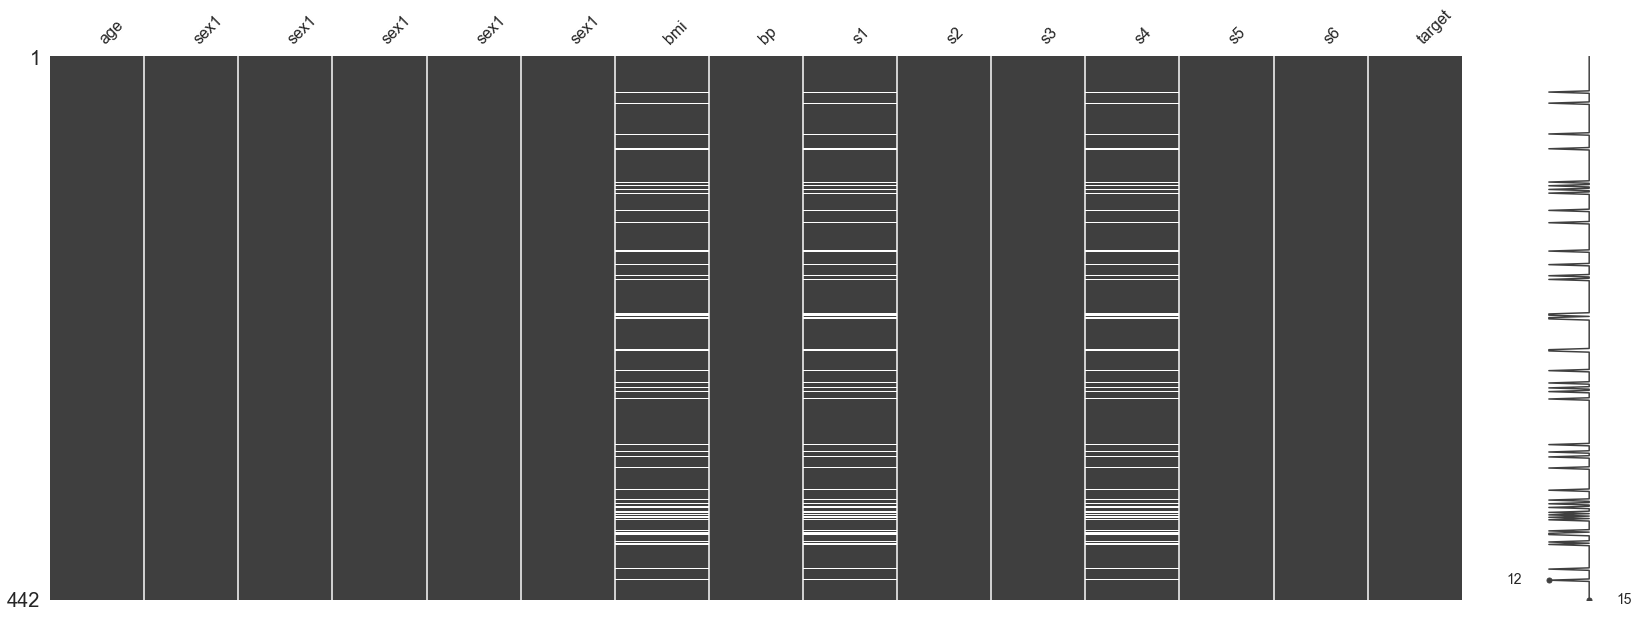

In [29]:
# Exercise 4

# The missingno package, imported as msno, has a function named matrix(), 
# which accepts a pandas.DataFrame as the first positional argument. Call the matrix() function on the diabetes DataFrame.

# Type your solution here:
msno.matrix(diabetes)

In [ ]:
# The missing value matrix arranges all observations vertically, starting from the first row in the diabetes DataFrame at 
# the top and descending to the last row at the bottom. Due to the compact display of 442 rows, 
# there's no visible gap between them. However, rows with missing values are distinguishable. For example,
# it's noticeable that the initial rows, such as the first 25, contain no missing data.
# This can be confirmed by identifying the index number of the first row with a missing bmi value:

In [30]:
diabetes.index[diabetes['bmi'].isna()][0]

29

In [ ]:
# You can see that, in fact, the first 29 rows do not have missing values.

# But the missing value matrix provides you with even more information in a very clear and concise way. It is easy to verify, thanks to this matrix, that whenever bmi is missing, s1 and s4 are also missing, and whenever bmi is not missing, s1 and s4 are not missing! This is confirmed by the sparkline on the right, which indicates the number of columns for which data is not missing for each observation. Here, you can clearly see that, for all observations, there are either 11 columns with non-missing data, or 8 columns with non-missing data (this applies to observations that have bmi, s1, and s4 missing). If you saw a data set like this without knowing how the missing values were created, you would immediately think that the observations are not missing at random. In other words, you would think that there is something about the observations with missing data that sets them apart in a systematic way from the observations that do not have missing data.

# A well-trained data scientist might conclude, on the basis of this missing value matrix and associated sparkline, that the missing observations likely came from a different data collection system, such as a different hospital that did not record bmi, s1 and s4 for its observations. This is because it would be extremely unlikely for s1 and s4 to be missing if and only if bmi was missing by random chance alone. Hence, there must be something systematic that sets those observations apart from the rest. Consequently, such a data scientist would not believe that the observations with missing data belong to the same group as those without missing data, and would consequently employ various strategies for dealing with grouped data.

# However, you have the luxury of knowing exactly how the data for these observations was set to missing. You know that you did this at random, first selecting 3 columns at random, then 10% of the rows at random, and then assigning missing values to the intersections of these rows and columns. As such, you know that, by construction, the data is missing at random. Therefore, you proceed forward on the basis of this knowledge. However, this exercise highlights the usefulness of the missing value matrix, which provides you with not only basic statistics regarding missing values, but also a visual structure of the missingness of the data.

# There are typically three different strategies for dealing with data that is missing at random:

#Dropping the observations with missing data
#Filling the observations with missing data with the mean
#Filling the observations with missing data with the median###

In [ ]:
# Drop missing observations
# The simplest strategy for dealing with rows that contain missing values is to drop them from the data set. 
# This is the most conservative approach because you do not speculate about the value of missing data, 
# you just disregard observations with missing feature values entirely. 
# The following code trains a linear regression model on a data set that had dropped the rows with missing data from the data 
# set. To evaluate the performance of this model, you also calculate the root mean squared error (RMSE) 
# of the prediction from the true value for the test set:

In [34]:
# linear regression dropping NANs

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

56.026782905782134

In [ ]:
# You end up with an RMSE of around 56.03.

# How good is an RMSE of 56.03? Well, you won't really know unless you compare the performance of this model to
# a few different model specifications. See if you can improve on the performance of this baseline prediction model 
# using the information obtained by EDA.

In [ ]:
# Fill in missing values with the mean
# One alternative to dropping all of the rows that contain missing data is to fill in missing values using either
# the mean or the median for the non-missing values in the column. Let's do exactly that, and run a regression model on 
# the resulting data set.

In [35]:
# linear regression with mean fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Fit the simple imputer using the training data
imp_mean.fit(X_train)
# Actually mean fill the training data
X_train_mean_filled = imp_mean.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_mean_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.731388480882835

In [ ]:
# First, it's important to recognize that the 'SimpleImputer' instance 'imp_mean' was exclusively trained on the training data. 
# Training the imputer on the entire data set would lead to a leakage of the test set into the imputer's mean calculation. 
# However, the test set should represent unseen data, not just for your linear regression model but also for the imputer.
# Therefore, it's crucial to restrict the training of the mean imputer to the training data only.

# Second, it's essential to note that you chose not to impute missing values in the test set. This decision was made to 
# ensure that you predict the exact same rows using both your mean imputation strategy and the strategy of dropping missing 
# values. Imputing missing values in the test set would effectively expand its size, contaminating the comparison
# between the two models' performances.

#Finally, it is worth highlighting that the mean imputation strategy resulted in a lower RMSE compared to simply dropping 
#rows with missing data. In this specific scenario, employing a mean imputation strategy enhanced prediction accuracy. 
#However, it is important to recognize that this outcome will not always occur: mean filling does not guarantee 
#improved performance over dropping rows with missing data, and the data scientist must experiment with different strategies 
#to minimize the generalization error.

In [ ]:
# Fill in missing values with the median
# Instead of filling in the missing value with the mean, you can also fill it in using the median. 
# Complete the following exercise to fill in missing values using the median.


# Exercise 5
# Replace the part that says ### REPLACE WITH YOUR CODE ### with your code to fill in missing values with the median. 
# The ### REPLACE WITH YOUR CODE ### part is found under the # Initialize the simple imputer header.



In [38]:
# linear regression with median fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.734308668473105

In [ ]:
#As observed, median filling yields an RMSE of 55.73, which is practically identical  
# (allowing for rounding errors up to 2 decimal places) to the RMSE obtained with the mean fill strategy.
# Given their comparable performance, the choice between these strategies is subjective and lies with the data scientist. 
# Considering that median filling is less influenced by extreme values, you opt for median filling in this instance.
# However, it's worth noting that choosing mean filling would have been equally acceptable.

In [ ]:
# Histograms and boxplots
# The following code generates histograms and boxplots for all numerical columns in the data set
# (that is, for all columns except sex1). Note that the following code can take more than 10 seconds to produce the plots,
# and that a significant number of plots will be created.

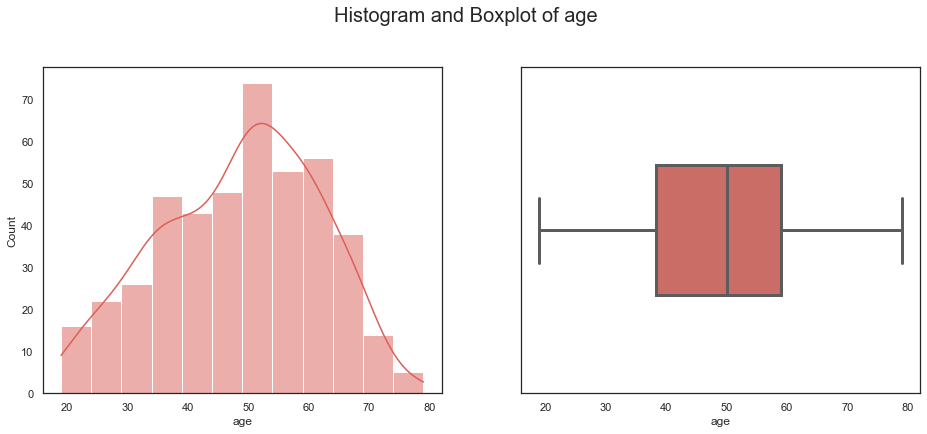

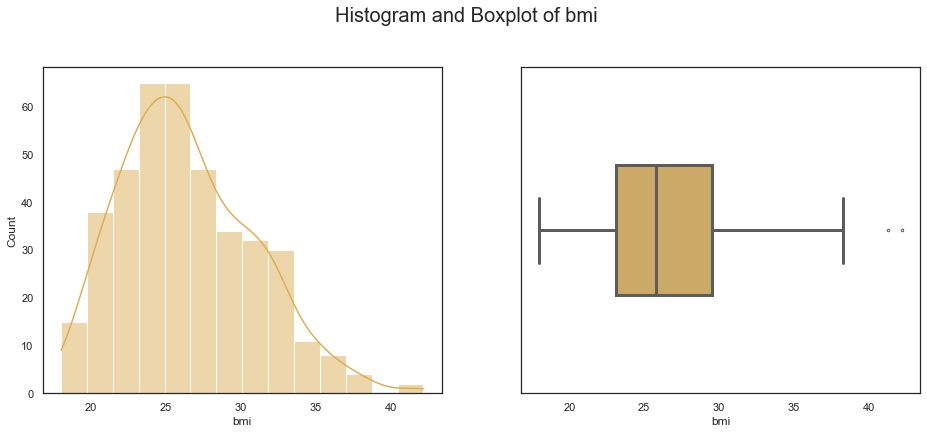

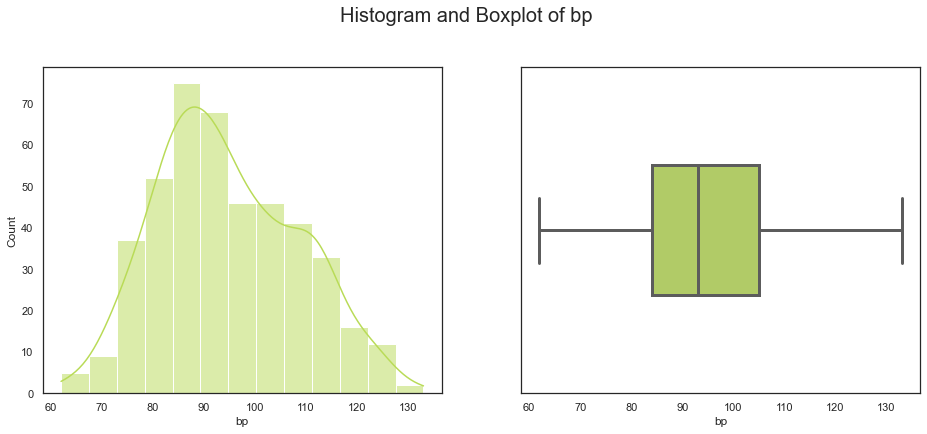

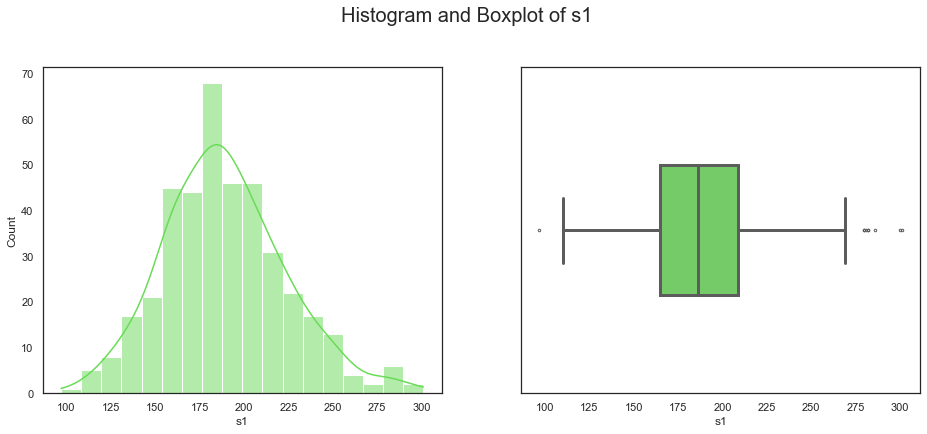

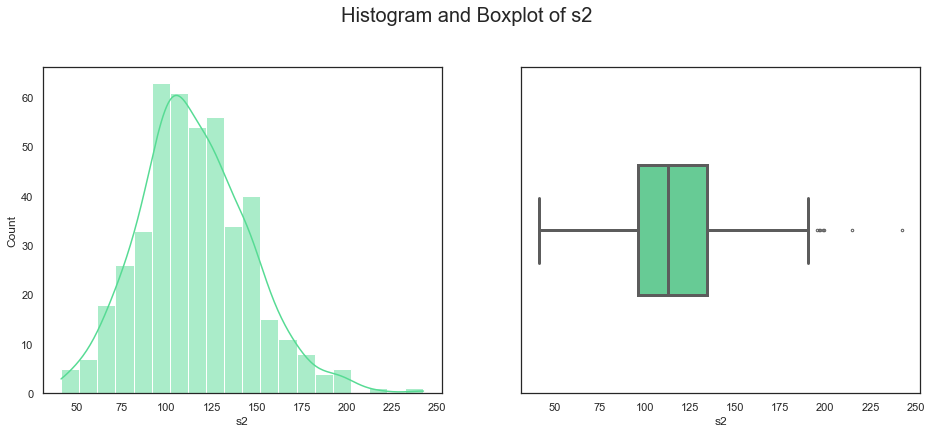

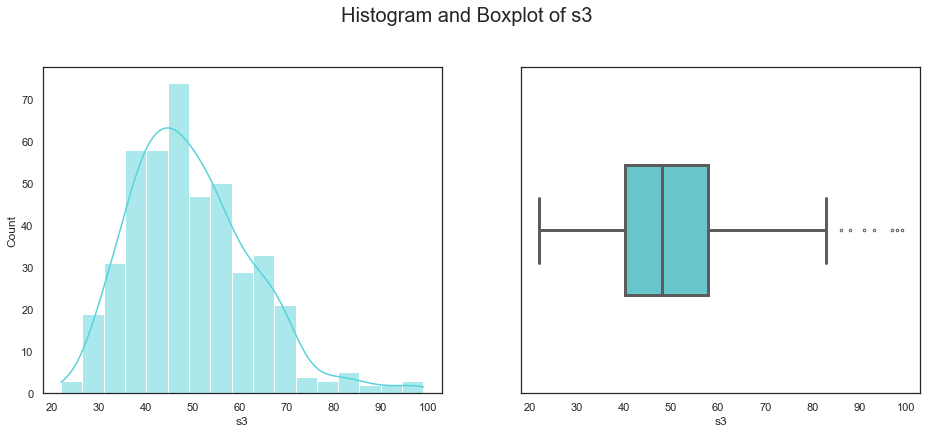

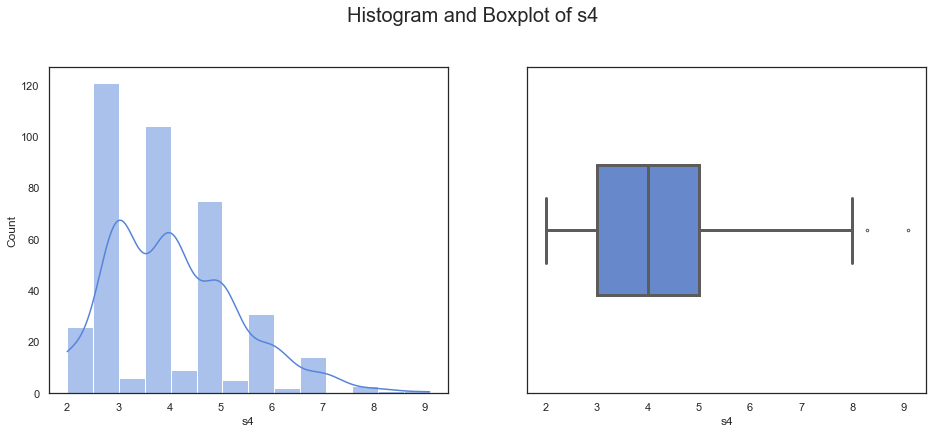

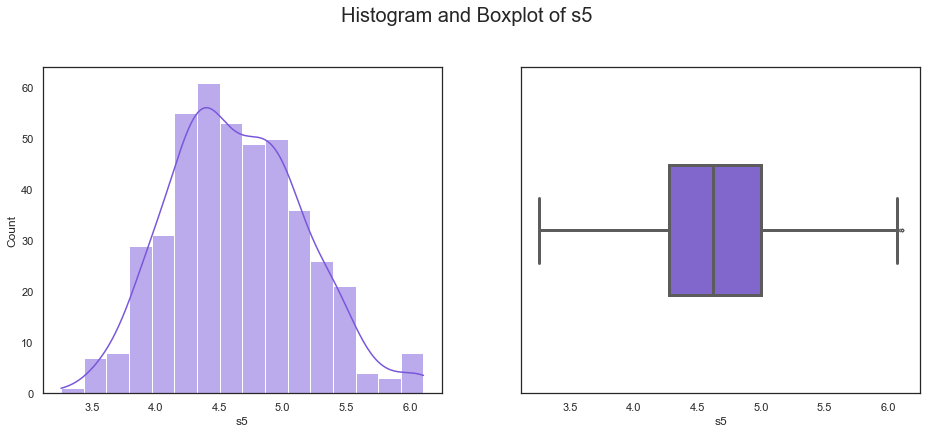

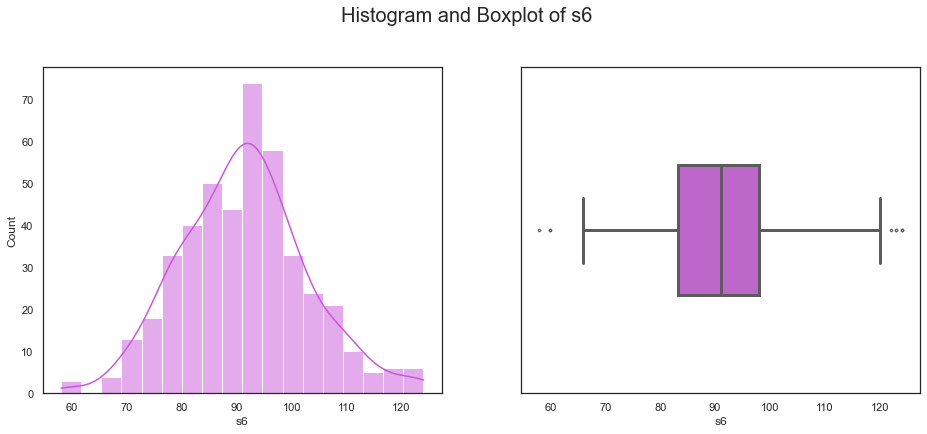

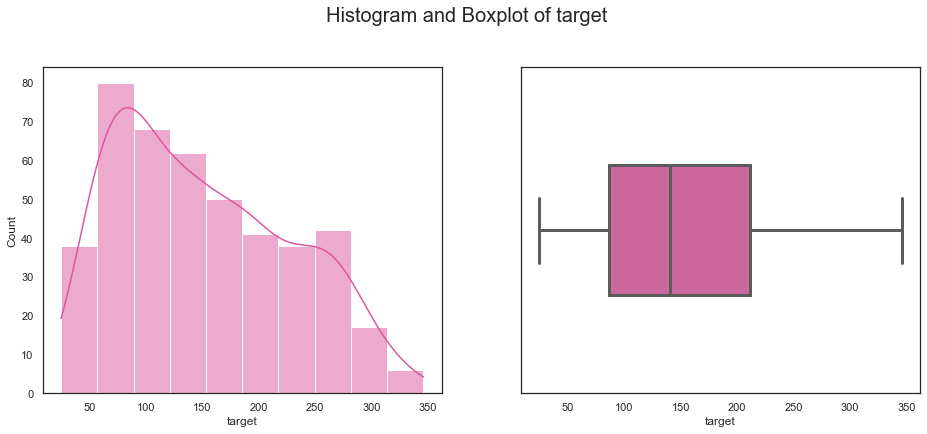

In [39]:
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [ ]:
# Histograms, shown towards the left, bin the data into equally sized bins and then show you the counts of the data in each bin. In addition to the histogram, each of the diagrams on the left provides a smoothed estimate of the density using a curve. These histograms and smoothed curves provide data scientists with a lot of information regarding the distribution of the individual variables. For instance, using histograms, you can visually confirm whether a variable is more or less normally distributed, or whether the data is skewed in a particular direction.

# The associated boxplots to the right indicate the ranges in which the bulk of the data lives (the box), the extent of the data excluding outliers (the whiskers), and the outliers (the fliers sometimes seen beyond the whiskers). Whether an extreme point is considered an outlier is determined using the interquartile range. Note that for some of the plots there are no outliers. Boxplots can be used to help identify the presence of outliers and to indicate whether the data is skewed in a particular direction.

# Use the information obtained using the histograms to try to improve your prediction model. In particular, focus on the s3 variable, which is a measure of the high-density lipid (HDL) cholesterol in the bloodstream. For simplicity, this histogram is reproduced in the following example.

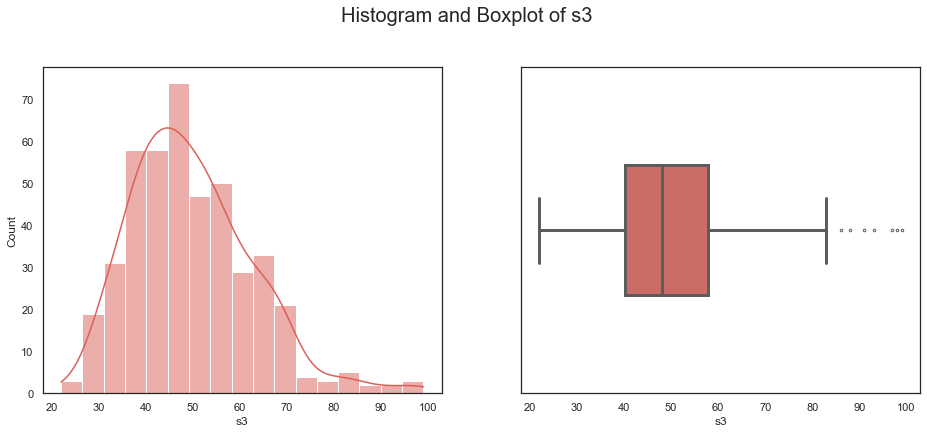

In [40]:
for idx, col in enumerate(['s3']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s3']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s3']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [ ]:
# Note that the distribution appears far from normal. Notably, there is a long right tail indicating some patients with 
# considerably higher HDL readings than the median patient. Additionally, according to basic statistical principles,
# a normal distribution extends from negative infinity to positive infinity. Therefore, for s3 to follow a normal distribution,
# it would need to theoretically permit negative readings. However, because s3 cannot be negative due to the nature of 
# cholesterol measurement, this distribution cannot be considered normal. A glance at the boxplot reinforces the view that 
#s3 deviates from normality. Finally, to confirm your suspicions, you could employ a statistical test of normality, 
# such as the Shapiro-Wilk test.

In [41]:
# normality test on s3
stat, p = shapiro(X_train['s3'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.962, p=0.000
Sample does not look normally distributed (reject H0)


In [ ]:
#Thus, you can clearly see that s3 is not normally distributed using a combination of:

#EDA (your analysis of the histogram and boxplot)
# Domain knowledge about what this variable represents
# A statistical test
# However, the histogram does indicate that the distribution might be log-normal,
# meaning that a natural logarithm of s3 might be normally distributed. Let's confirm whether this is likely the case using
# the Shapiro-Wilk test in the following exercise.

In [ ]:
# Exercise 6

Replace the part that says ### REPLACE WITH YOUR CODE ### to run the Shapiro-Wilk test on the natural logarithm of s3. Note that a natural logarithm could be taken using the log() function from the NumPy package.

In [42]:
# normality test on log of s3
stat, p = shapiro(np.log(X_train['s3']))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.996, p=0.700
Sample looks normally distributed (fail to reject H0)


In [ ]:
# In this case, you see that, according to the Shapiro-Wilk test, the log of s3 is normally distributed!

# Now, to benefit from this information, let's provide some context that is slightly outside the scope of this project. For a linear regression model to be valid, you need the residuals resulting from the prediction to be normally distributed. A violation of this normality assumption could occur if the data is not linearly related or if some of the features (or the target itself) are not normally distributed. Using this fact and the knowledge that you just obtained through EDA, you can realize that you can probably improve your prediction model by simply taking the log of s3. Note that you will continue to fill in missing values with the median, as you have done before.

In [43]:
# linear regression with median fill, and using the log of 's3'

X_train['s3'] = np.log(X_train['s3'])
X_test['s3'] = np.log(X_test['s3'])

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.5418228120948

In [ ]:
# Just as suspected, you have an improvement in performance! Simply replacing s3 with the natural logarithm of s3 caused the RMSE to drop from 55.73 to 55.54. Thus, you have been able to incrementally improve your prediction model thanks to your keen eye when looking at the histogram, your knowledge of the log-normal distribution, and your knowledge of the inner workings of the linear regression model!

# Can you do even better? Of course you can! For instance, you can use the box plots to eliminate observations that contain outliers from the training set. For example, look at the histogram and boxplot for s2:

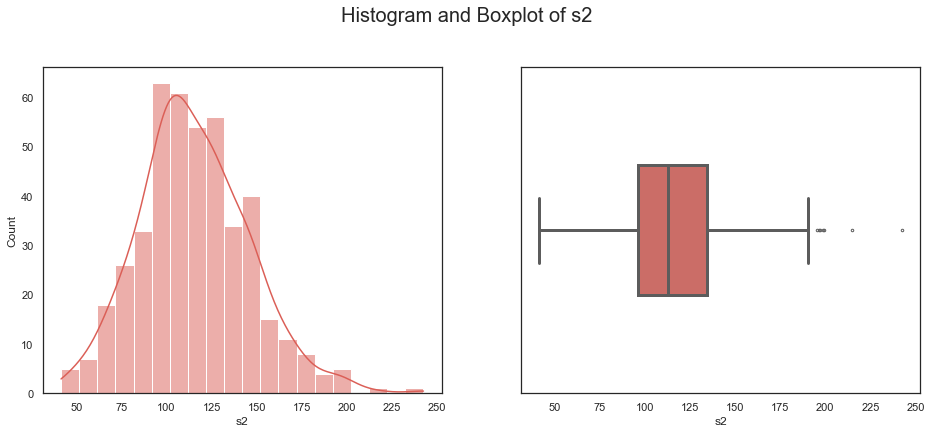

In [44]:
for idx, col in enumerate(['s2']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s2']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s2']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [ ]:
# Here, notice that you have extreme outliers that are very far from the bulk of the observations. Let's remove some of these outliers from the training set to see if you can improve your prediction further. The following code removes just one of those outliers, the most extreme observation.

In [45]:
# linear regression with median fill, using the log of 's3', and removal of outlier from 's2':

# Outlier removal
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.3666304777134

In [ ]:
# Once again, you were able to improve the accuracy of the prediction, this time from 55.54 to 55.37. Note that, prior to engaging in EDA, your RMSE was 56.02 with the baseline model that simply eliminated rows with missing data. Throughout this entire analysis, you did not change the model itself or tune any hyperparameters. Rather, you took advantage of your increasing knowledge of the data set to incrementally improve your prediction model by transforming the data and by subsetting the training set to those observations that are most likely to make a model that generalizes well.

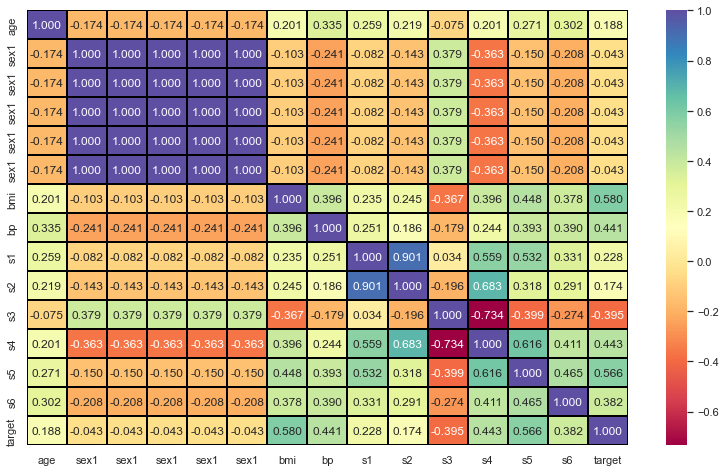

In [46]:
# Correlation matrix
# The following code generates a correlation matrix.


plt.figure(figsize = (12, 8))
sns.heatmap(diabetes.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')
plt.show()

In [ ]:
# A correlation matrix shows the Pearson correlation coefficient between various pairs of variables. The Pearson correlation coefficient shows the strength and direction of the linear relationship between two variables, with -1 indicating a perfect negative linear relationship and +1 indicating a perfect positive linear relationship. To enhance readability, the previous correlation matrix is presented in the form of a heatmap, with high correlations being blue, and low correlations being red, as indicated by the right-hand bar beside the correlation matrix.

# The previous correlation matrix indicates that s1 and s2 have a very strong positive linear relationship: their correlation is 0.901. Moreover, you see that neither s1 nor s2 are very correlated with the target, as both of their correlations are close to zero. This raises the question about whether including both s1 and s2 is necessary within the same model Perhaps the inclusion of one of these variables is sufficient. Let's test this assumption by excluding s1 from the analysis.

In [52]:
# linear regression with median fill, using the log of 's3', removal of outlier from 's2', and the dropping of 's1':
"""
# Outlier removal (commented out because `X_train` and `y_train` are already updated)
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices (commented out because these indices did not change)
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]
"""
# Get column names that do not include 's1'
cols_no_s1 = [i for i in X_train.columns if i != 's1']

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train.loc[:, cols_no_s1])
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train.loc[:, cols_no_s1])

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices, cols_no_s1])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.32347715027474

In [ ]:
# You can see that the performance of the model without s1 is only slightly worse than the performance of the model with s1. Consequently, you can draw the conclusion that s1 does not significantly improve the predictive capabilities of the linear regression model when s2 is present.

# This information could be useful for you for a number of reasons. For instance, if s1 was a variable that is frequently missing or expensive to collect, it might be desirable to design a model that excludes it entirely if it does not contribute much to the predictive power of the model. Additionally, simpler models are easier to understand, and if interpretability were a goal, s1 would be a great candidate to drop from the analysis. None of these insights would have been easily obtained without looking at the correlation matrix.

In [ ]:
# Pair plots
# The following code outputs the pair plots for the diabetes data set.

In [54]:
# This code may take a minute or two to finish running
sns.pairplot(diabetes)
plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# A simple function to perform EDA
# The fasteda package includes a function called fast_eda that performs all of the previous analysis using one easy-to-remember command.

In [50]:
# This code may take a minute or two to finish running
fast_eda(diabetes)

DataFrame Head:


,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,0.0,0.0,0.0,0.0,0.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,1.0,1.0,1.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,0.0,0.0,0.0,0.0,0.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0


DataFrame Tail:


,age,sex1,sex1,sex1,sex1,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
439,60.0,0.0,0.0,0.0,0.0,0.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,1.0,1.0,1.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0
441,36.0,1.0,1.0,1.0,1.0,1.0,19.6,71.00,250.0,133.2,97.0,3.00,4.5951,92.0,57.0


----------------------------------------------------------------------------------------------------
Missing values:


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [55]:
# Load the data set from sklearn
iris_sklearn = load_iris()

# Extract the data and target labels as a numpy array
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis=1)

# Define column names
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Convert the numpy array to a pandas dataframe with column names
iris = pd.DataFrame(iris_npy, columns=col_names)

# Print a description of the dataset
print(iris_sklearn['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [56]:
# take a look at target colunm

iris['target'].sample(5)

24     0.0
104    2.0
85     1.0
10     0.0
148    2.0
Name: target, dtype: float64

In [57]:
class_names = dict(zip(list(map(float, range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))
print(class_names)

{0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'}


In [ ]:
# Perform EDA on the iris data set
# Complete the following exercise to perform EDA on the iris data set.

DataFrame Head:


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0


DataFrame Tail:


,sepal_length,sepal_width,petal_length,petal_width,target
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0
149,5.9,3.0,5.1,1.8,2.0


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(150, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
sepal_length,150,5.843,5.8,0.828,4.3,5.1,5.8,6.4,7.9,0.311753,-0.573568
sepal_width,150,3.057,3,0.436,2,2.8,3,3.3,4.4,0.315767,0.180976
petal_length,150,3.758,4.35,1.765,1,1.6,4.35,5.1,6.9,-0.272128,-1.395536
petal_width,150,1.199,1.3,0.762,0.1,0.3,1.3,1.8,2.5,-0.101934,-1.336067
target,150,1,1,0.819,0,0,1,2,2,0.000000,-1.500000


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



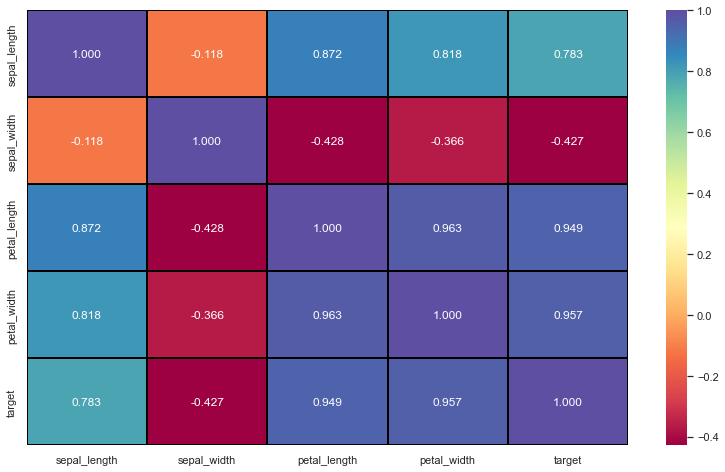

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



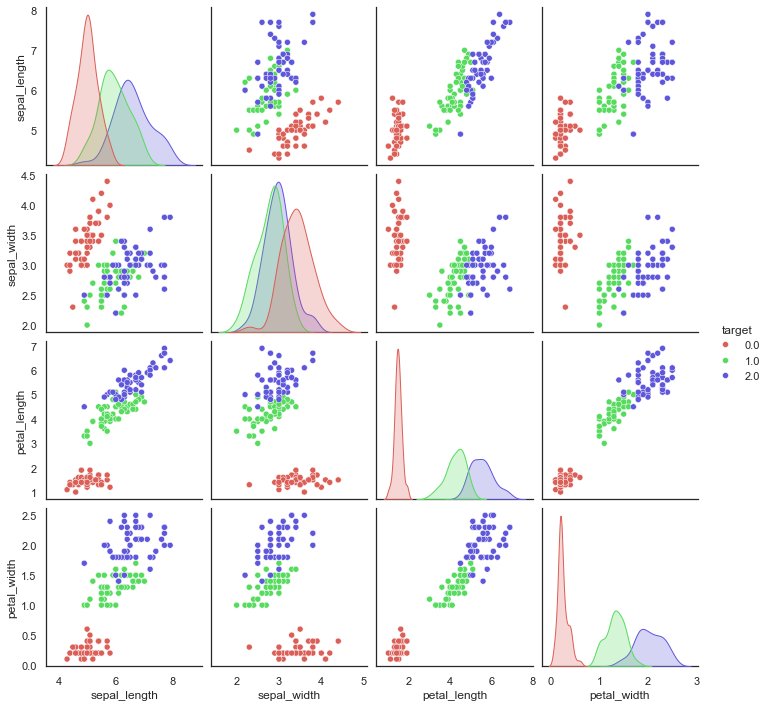

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



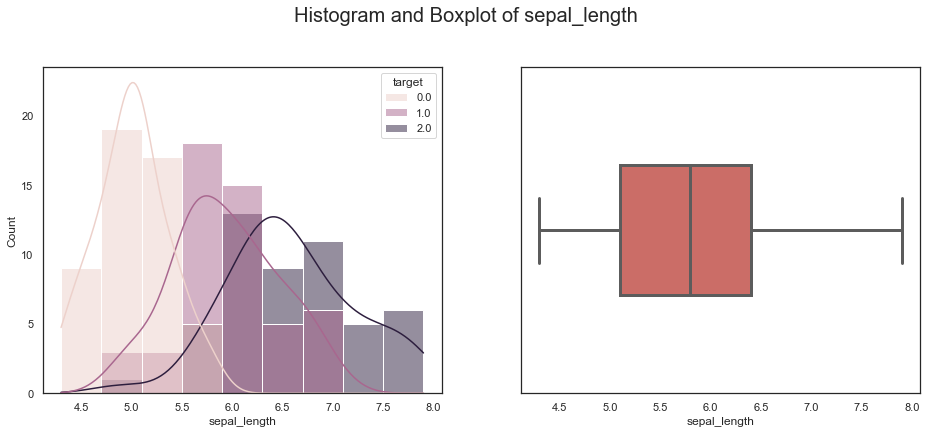

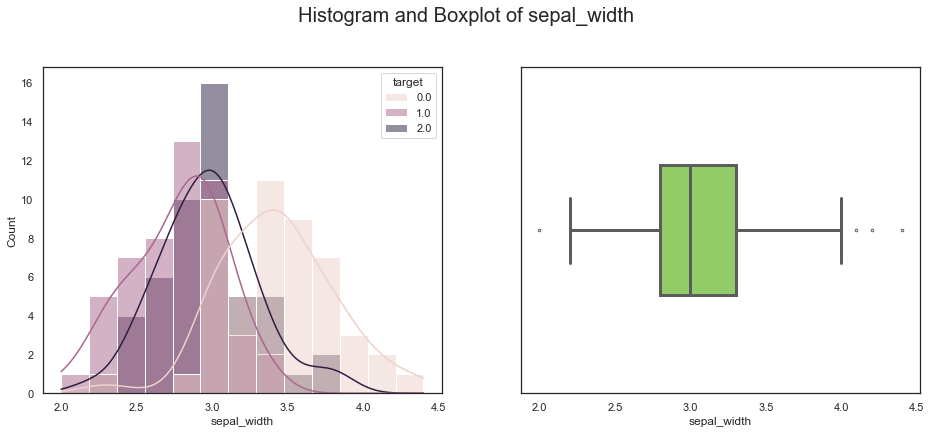

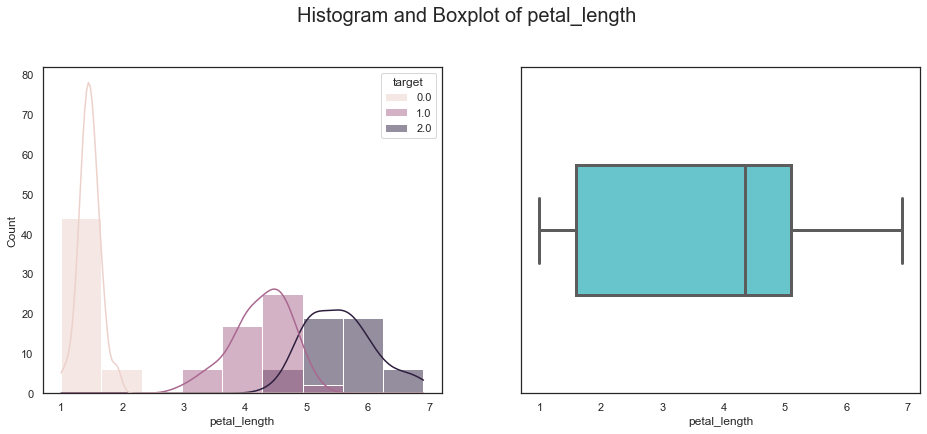

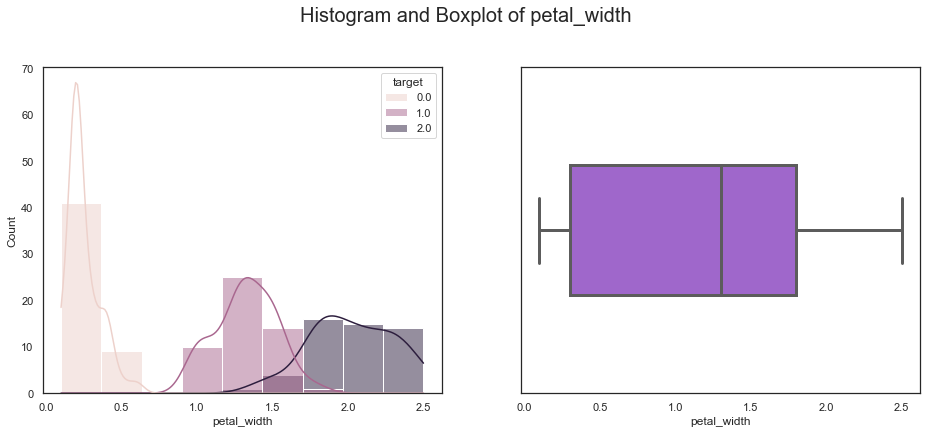

----------------------------------------------------------------------------------------------------
Countplot(s):



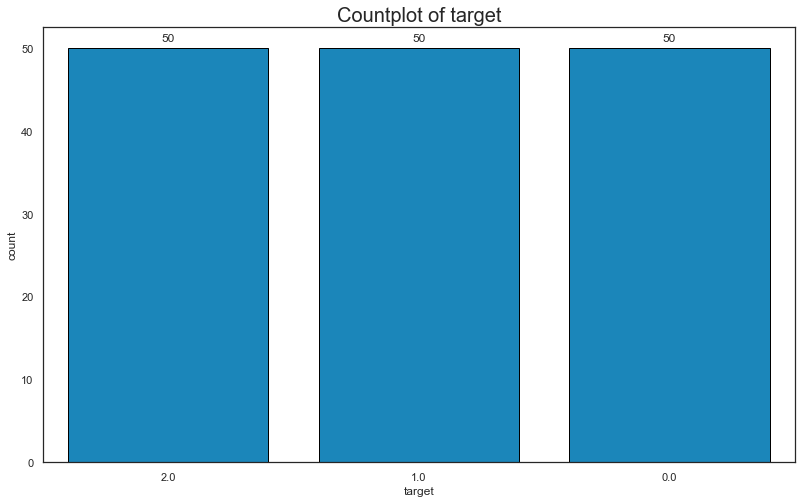

In [58]:
fast_eda(iris, target='target')

In [ ]:
# As seen in the previous plots, setting the target parameter in fast_eda changes the way pair plots and histograms are drawn. For pair plots, the scatter plots off the main diagonal are color-coded by the target class, which helps in identifying pairs of features that could separate the classes well. For instance, consider the scatter plot that has petal width on the horizontal axis and sepal width on the vertical axis.

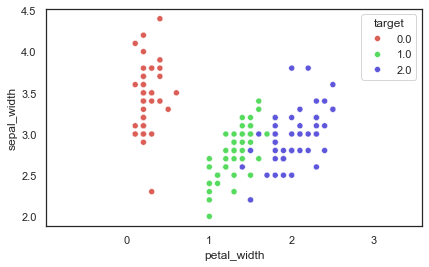

In [59]:
plt.axis('equal')
sns.scatterplot(iris, x='petal_width', y='sepal_width', hue='target', palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

In [ ]:
# It's evident that petal width alone can effectively distinguish the setosa class from the others. Conversely, sepal width alone isn't adequate to isolate the setosa class. However, when considering the versicolor and virginica classes, you see that higher values of both sepal width and petal width tend to correspond to the virginica class (encoded as 2.0), whereas lower values of both features are associated with the versicolor class (encoded as 1.0). Consequently, you recognize that the combination of sepal and petal widths can better differentiate these two classes compared to either feature in isolation. Specifically, higher sepal width is more likely to indicate the virginica class when accompanied by higher petal width.

# Note that the histograms produced by fast_eda are also presented by class, and this can help you identify differences in the distributions of feature values for the different classes. For instance, consider the histogram for sepal length.

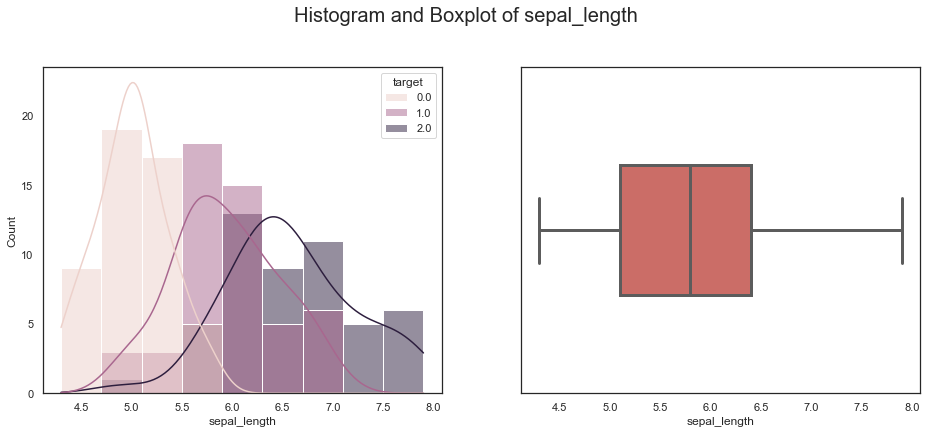

In [60]:
for idx, col in enumerate(['sepal_length']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(iris, x = iris[col], kde = True,
                 color = sns.color_palette("hls", iris['target'].nunique()), ax = ax1, hue = 'target')
    sns.boxplot(x = iris[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", iris['target'].nunique())[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [ ]:
# This histogram indicates that the versicolor and virginica classes appear to be far more dispersed than the setosa class. This, in turn, indicates that it is very unlikely for you to see flowers in the setosa class having a sepal length greater than 6.5, but it is possible (though still unlikely) for the versicolor and virginica classes to have sepal lengths as low as 4.5. Therefore you can conclude that, for example, an observation with a sepal length of 5 could belong to any of the classes with a reasonably high degree of probability, but an observation with a sepal length of 7.5 will almost surely not belong to the setosa class. These types of observations would not be easily made without histograms that visually split the data by class.

# The final major item to consider when dealing with a classification data set is the class balance, or the proportion of observations that belong to each class. Many prediction algorithms perform poorly in the presence of unbalanced data. In other words, when there are relatively few examples for some classes. Class balance can be seen using the countplot generated by fast_eda, but sometimes it is better to visualize that data using a pie chart instead. Complete the following exercise to generate a pie chart that indicates the class balance of the iris data set.

In [ ]:
# Exercise 8¶
# Replace the part that says ### REPLACE WITH YOUR CODE ### to generate a pie chart showing the relative proportion of each class. Note that value counts can be obtained using the pandas.Series .value_counts() method.

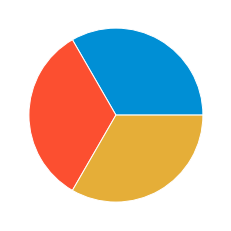

In [61]:
# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc)

In [ ]:
# An even prettier pie chart, one that shows the exact percentages of each class as well as the number of observations belonging to each class, can be made using:

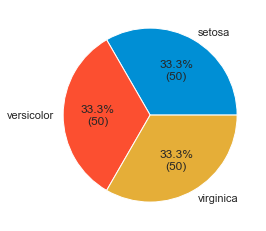

In [62]:
# Inspired by:
#https://stackoverflow.com/questions/73616867/pie-chart-from-count-of-values-showing-the-percentage/73617021#73617021

# Define a function to format value counts into percentages
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc, labels = vc.rename(class_names).index, autopct=autopct_format(vc))